## **Collegamento Google Drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

## **Import librerie**

In [ ]:
#import utils
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocessing
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import iirnotch
from scipy.signal import resample
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt
from skimage.restoration import denoise_wavelet

#PCA
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

#Feature extraction
from statsmodels.robust import mad as median_deviation 
from scipy.stats import iqr as IQR # import interquartile range function (Q3(column)-Q1(column))
from scipy.stats import entropy # import the entropy function

## **Downsampling da 1000Hz a 200Hz**

In [ ]:
def downsampling_function (channel):
    """
    Downsampling di un singolo canale di un segnale EEG rappresentato come un array NumPy 1D.
    INPUT -------> column (numpy.ndarray): singolo canale del segnale EEG rappresentato come array NumPy 1D.
    OUTPUT ------> numpy.ndarray: il canale sottocampionato rappresentato come array NumPy 1D.
    """

    #frequenza di campionamento iniziale
    fs_initial = 1000  # Hz
    # Definisce la nuova frequenza di campionamento desiderata
    fs_final = 200  # Hz

    # Calcola il fattore di downsampling
    downsampling_factor = int(fs_initial / fs_final)

    # Applica il downsampling al segnale
    t_downsampled = resample(t_signal, int(len(t_signal)/downsampling_factor))

    # Restituisce il canale sottocampionato rappresentato come array NumPy 1D
    return t_downsampled

## **Filtro mediana**

In [ ]:
def median_filter(signal):# input: numpy array 1D (one column)
    """
    Implementa il filtro mediana
    INPUT -------> channel (numpy.ndarray): canale su cui applicare il filtro 
    OUTPUT ------> numpy.ndarray: canale filtrato con il filtor mediana
    """
    array=np.array(signal)   
    #applying the median filter
    median_filtered=scipy.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  median_filtered 

## **Filtro notch**

In [ ]:
def notch_filter(channel):
    """
    Implementa il filtro notch IIR notch filter, metodo fornito nella libreria scipy.signal e lo applica su un singolo canale del segnale
    INPUT -------> column (numpy.ndarray): canale su cui applicare il filtro 
    OUTPUT ------> numpy.ndarray: canale filtrato dalla frequenza 50 HZ
    """
    #Frequenza di campionamento del segnale in ingresso
    fs= 200.0
    # frequenza centrale del filtro notch
    f0= 50.0
    #fattore di qualità del filtro
    Q= 30.0 

    b, a = iirnotch(f0, Q, fs)
    filtered_channel = signal.filtfilt(b, a, channel)
    return filtered_channel

## **Filtro passabanda tra 1 e 35 Hz**

In [ ]:
def bandpass_filter(channel):
    """
    Implements a bandpass filter using the butterworth filter design method provided in scipy.signal on a single channel of a multi-channel signal
    INPUT -------> channel (numpy.ndarray): canale su cui applicare il filtro 
    OUTPUT ------> numpy.ndarray: canale filtrato nel range di frequenza 1-35 Hz
    """
    # Frequenza di campionamento del segnale in ingresso
    fs = 200.0
    # Definisci le frequenze di taglio del filtro passa-banda
    lowcut = 1.0  # Frequenza di taglio inferiore (1 Hz)
    highcut = 35.0  # Frequenza di taglio superiore (35 Hz)
    # Ordine del filtro
    order = 5

    # Calcola le frequenze di taglio normalizzate
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Progetta i coefficienti del filtro Butterworth
    b, a = butter(order, [low, high], btype='band')

    # Applica il filtro passa-banda al canale
    filtered_channel = filtfilt(b, a, channel)

    return filtered_channel

## **Caricamento dati + Preprocessing**

In [ ]:
# dizionario in cui memorizzare i segnali preprocessati
preprocessed_dic={}

#scorre le sessioni 1, 2 e 3
for i in range(1, 4):
  eeg_raw_data = f'/content/drive/Shareddrives/biometria_progetto/eeg_raw_data/{i}'
  # Controlla se il percorso della cartella esiste
  if os.path.exists(eeg_raw_data):
    #scorriamo tutti i file dei partecipanti
    for file in os.listdir(eeg_raw_data):
      #prendiamo il path di ogni file del partecipante
      path = os.path.join(eeg_raw_data, file)
      #Carica i dati dal file .mat
      mat_file = scipy.io.loadmat(path)
      #si memorizzano tutte le chiavi presenti nel file .mat
      exclude_keys = ['__header__', '__version__', '__globals__']
      keys = [key for key in mat_file.keys() if key not in exclude_keys]
     
      #scorre ogni chiave e per ogni segnale contenuto in esso crea un dataframe pandas
      for data_file in keys:
        data = mat_file[data_file]
        data= data.T
        
        # Crea un DataFrame di Pandas con i dati
        columns = ['Channel_' + str(i) for i in range(data.shape[1])]
        df = pd.DataFrame(data, columns=columns)
        
        #PREPROCESSING
        #creiamo un dataframe temporaneo in cui salvare i valori ottenuti dal preprocessing
        tmp_df=pd.DataFrame() 
        
        for column in df.columns:
          t_signal=np.array(df[column])  # Copia i valori del segnale in un array numpy 1D
          #effettuo il sottocampionamento
          signal_downsampled = downsampling_function (t_signal)
          # applico filtro media
          med_filtred=median_filter(signal_downsampled)
          # applico il filtro Notch 
          signal_notch =  notch_filter(med_filtred)
          #applico filtro passa banda
          band_pass =bandpass_filter(signal_notch)
          #applico la trasformata di wavelet
          wavelet_transform=denoise_wavelet(band_pass,method='BayesShrink',mode='hard',wavelet='sym9',wavelet_levels=5,rescale_sigma=True)
          #applico il filtro Savitzky–Golay 
          tmp_df[column] = savgol_filter(wavelet_transform, 1111, 3,mode='wrap')

        #indicizzo il dizionario con la chiave che sarà del tipo {Sessione}_{InizialePartecipante}_eeg{NumeroSegnale} ex. '1_cz_eeg22'
        preprocessed_dic[f"{i}_" + data_file] = tmp_df
        del df

      del mat_file
  else:
      print("Il percorso della cartella non esiste.")

#memorizzo tutte le chiavi del dizionario
keystotal=[]
keystotal=preprocessed_dic.keys()       

## Segnale random *prima* del preprocessing

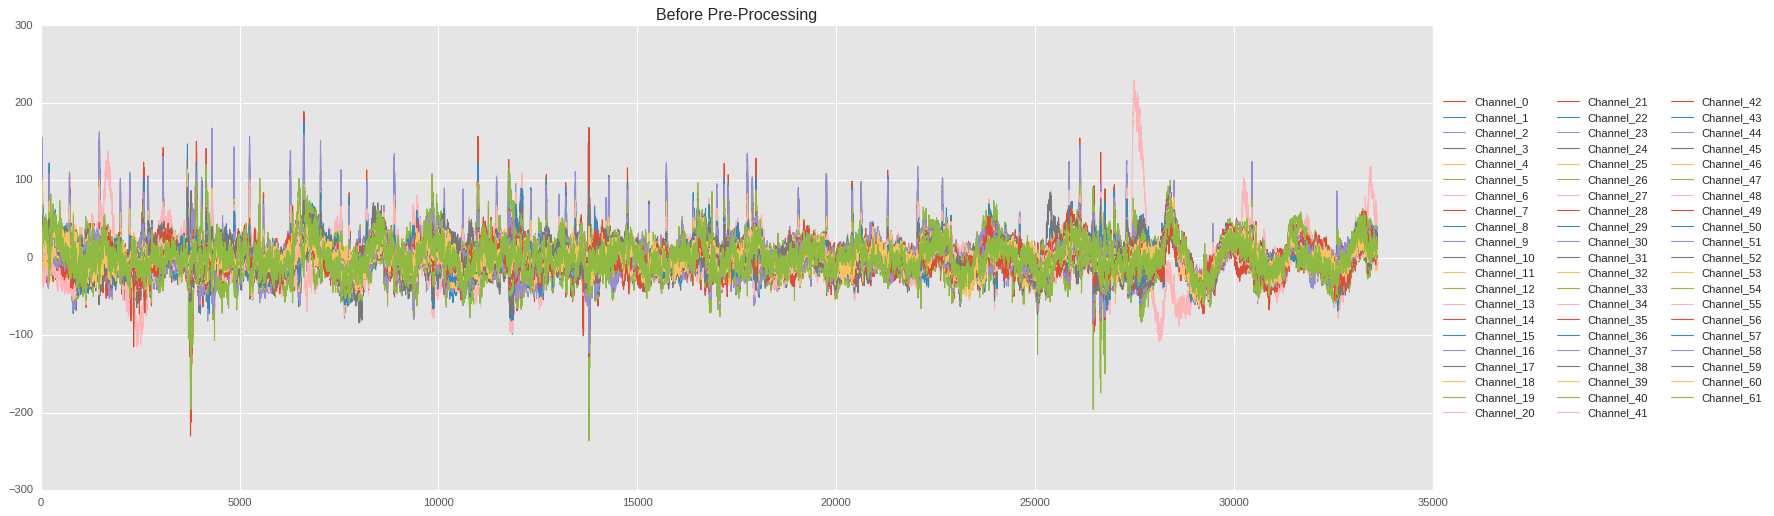

In [ ]:
mat_file = scipy.io.loadmat('/content/drive/Shareddrives/biometria_progetto/eeg_raw_data/1/1_20160518.mat')
data = mat_file['cz_eeg1']
data= data.T

# Crea un DataFrame di Pandas con i dati
columns = ['Channel_' + str(i) for i in range(data.shape[1])]
before_preprocessing = pd.DataFrame(data, columns=columns)

#crea il grafico
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 7))
before_preprocessing.plot(ax=ax, linewidth=1.0)
plt.title("Before Pre-Processing")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)



## Segnale random *dopo* il preprocessing

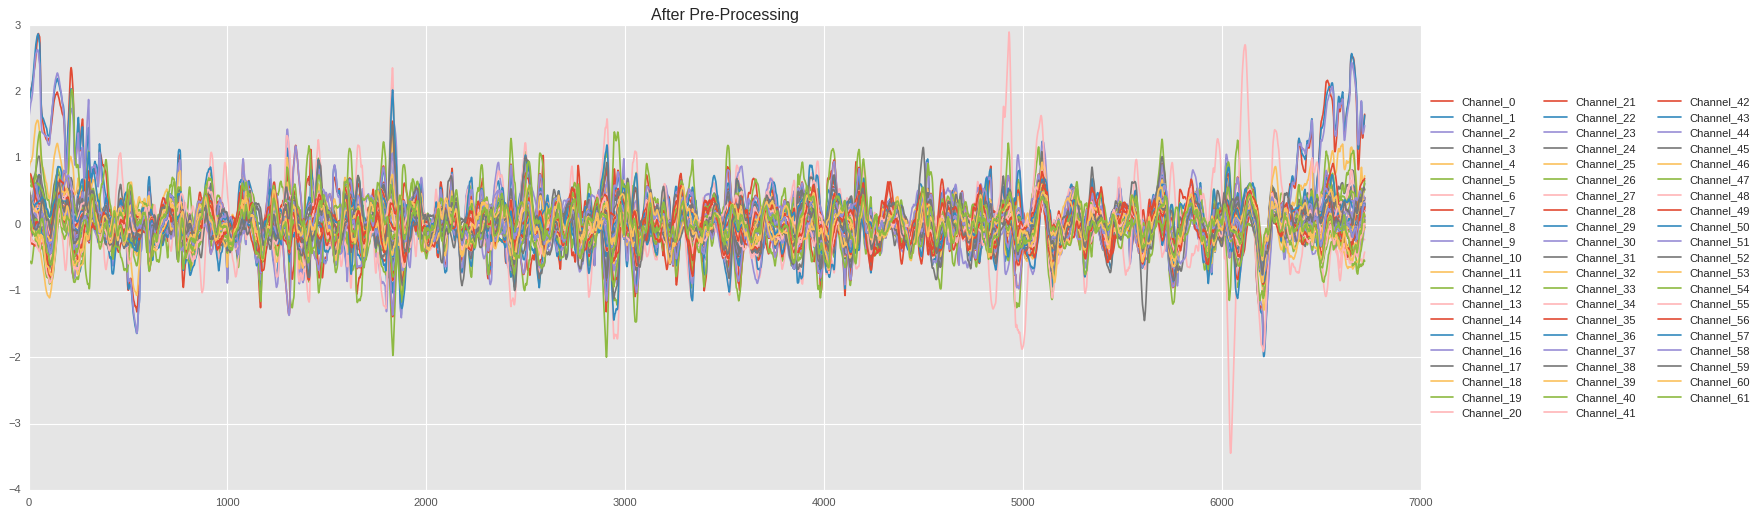

In [ ]:
after_preprocessing= preprocessed_dic['1_cz_eeg1']

#crea il grafico
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 7))
after_preprocessing.plot(ax=ax, linewidth=1.5)
plt.title("After Pre-Processing")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)

## **PCA**

In [ ]:
#Implementazione PCA (Principal Component Analysis) per ottenere 5 set di dati invece dei 62 

#raggruppiamo i canali in base all'area considerata
prefrontal = ['Channel_0', 'Channel_1', 'Channel_2', 'Channel_3', 'Channel_4'] #FP1, FPZ, FP2, AF3, AF4
frontal = ['Channel_5', 'Channel_6', 'Channel_7', 'Channel_8', 'Channel_9', 'Channel_10', 'Channel_11', 'Channel_12', 'Channel_13'] #F7, F5, F3, F1, FZ, F2, F4, F6 e F8.
central = ['Channel_24', 'Channel_25', 'Channel_26', 'Channel_27', 'Channel_28', 'Channel_29','Channel_30'] #C5, C3, C1, CZ, C4, C6
parietal = ['Channel_41', 'Channel_42', 'Channel_43', 'Channel_44', 'Channel_45', 'Channel_46','Channel_47'] #P7, P5, P1, PZ, P2, P4, P5, P8
occipital = ['Channel_50', 'Channel_51', 'Channel_52', 'Channel_53', 'Channel_54', 'Channel_55','Channel_56','Channel_58','Channel_59','Channel_60'] #P07, P05, P03, P02, P04 ,P02, P04, P05, P08

#Applichiamo PCA per ogni gruppo

# Dizionario per contenere i dataframe con le componenti principali
dataframes_pca = {}

for k in keystotal:
    df=preprocessed_dic[k] 

    # Estrai solo i canali specifici
    df_prefron = df[prefrontal]
    df_fron = df[frontal]
    df_cen = df[central]
    df_par = df[parietal]
    df_occ = df[occipital]

    #Crea un oggetto PCA con un'unica componente principale
    pca_com = PCA(n_components=1)

    # Calcola la componente principale per ciascun gruppo
    component_prefron = pca_com.fit_transform(df_prefron)
    component_fron = pca_com.fit_transform(df_fron)
    component_cen = pca_com.fit_transform(df_cen)
    component_par = pca_com.fit_transform(df_par)
    component_occ = pca_com.fit_transform(df_occ)


    # Crea un nuovo DataFrame con la componente principale per ciascun gruppo
    df_component = pd.DataFrame({
        'Prefrontal_PCA': component_prefron.flatten(),
        'Frontal_PCA': component_fron.flatten(),
        'Central_PCA': component_cen.flatten(),
        'Parietal_PCA': component_par.flatten(),
        'Occipital_PCA': component_occ.flatten()
    })

    # Memorizza il DataFrame delle componenti principali nel dizionario dataframes_pca
    dataframes_pca[k] = df_component

## Segnale random *dopo* PCA

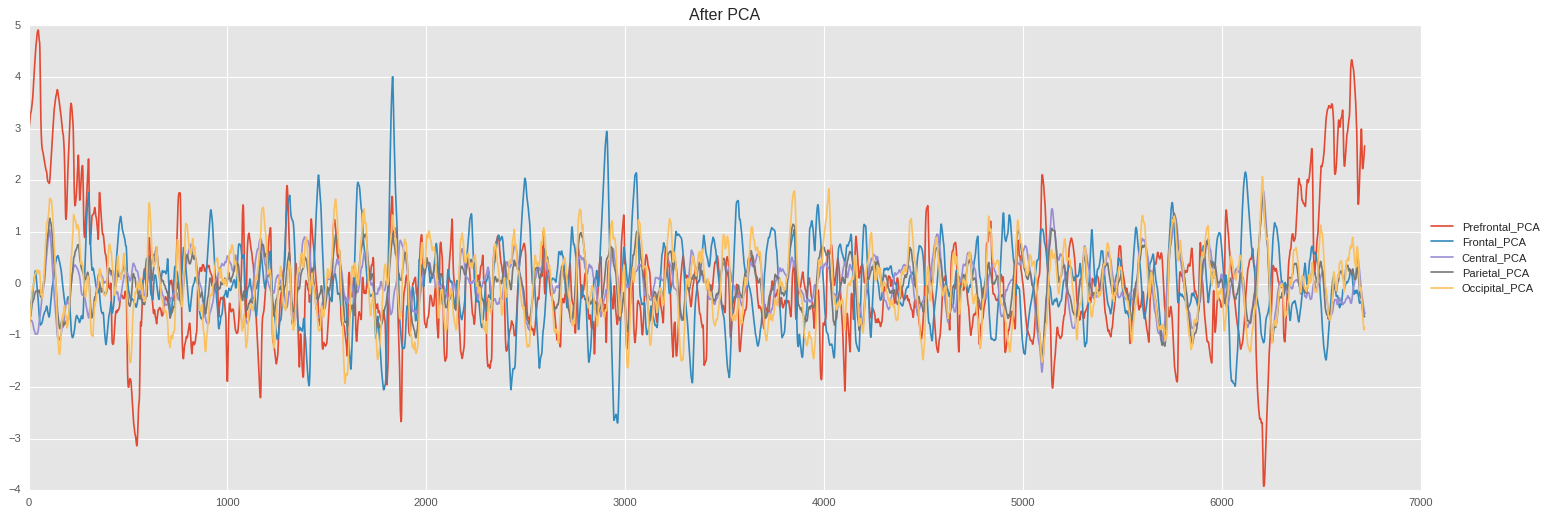

In [ ]:
signal_pca= dataframes_pca['1_cz_eeg1']

#crea il grafico
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 7))
signal_pca.plot(ax=ax, linewidth=1.5)
plt.title("After PCA")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

## **Definizioni funzioni feature extraction**

In [ ]:
# mean
def mean_function(df):
    array=np.array(df) # convert dataframe into 2D numpy array for efficiency
    mean_vector = array.mean(axis=0) # calculate the mean value n
    return mean_vector # return mean vetor

# std
def std_function(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    std_vector =array.std(axis=0)# calculate the standard deviation value             
    return std_vector

# mad
def mad_function(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    mad_vector = median_deviation(array,axis=0) # calculate the median deviation value
    return mad_vector

# max
def max_function(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    max_vector=array.max(axis=0)# calculate the max value
    return max_vector

#min
def min_function(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    min_vector=array.min(axis=0)# calculate the min value 
    return min_vector

#IQR
def IQR_function(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    IQR_vector=np.apply_along_axis(IQR,0,array)# calculate the inter quartile range value  
    return IQR_vector

# Shannon entropy
def entropy_function(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    entropy_vector=np.apply_along_axis(entropy,0,abs(array))# calculate the entropy value 
    return entropy_vector

# energy
def t_energy_function(df):
    array=np.array(df)
    energy_vector=(array**2).sum(axis=0) # energy value of each df column
    return energy_vector # return energy vector energy_X,energy_Y,energy_Z   


## **Feature extraction**

In [ ]:
signal_extraction = pd.DataFrame(columns=range(40))

for key, df in dataframes_pca.items():
  mean_vector   = list(mean_function(df)) 
  std_vector    = list(std_function(df)) 
  mad_vector    = list(mad_function(df))
  max_vector    = list(max_function(df))
  min_vector    = list(min_function(df))
  energy_vector = list(t_energy_function(df))
  IQR_vector    = list(IQR_function(df))
  entropy_vector= list(entropy_function(df))
  #concateniamo tutti i valori ottenuti
  t_vector= mean_vector + std_vector + mad_vector +max_vector+ min_vector+ IQR_vector + energy_vector  + entropy_vector 
  signal_extraction.loc[len(signal_extraction.index)] = t_vector

## **Salvataggio dati preprocessati**

In [ ]:
#memorizziamo anche le chiavi per identificare ogni segnale
signal_extraction['Key']= keystotal

#salviamo i dati in un file csv
signal_extraction.to_csv('/content/drive/Shareddrives/biometria_progetto/preprocessed_data.csv', index=False)

## **MOVIMENTI OCULARI**

In [ ]:
# Colleghiamo Google Drive a Google Drive 
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#import librerie
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

In [ ]:
#creo un dizionario (struttura dati che rappresenta coppie chiave-valore) in cui memorizzare i segnali preprocessati
eyemoviment_dic={}

#scorri le sessioni 1, 2 e 3
for i in range(1, 4):
  eye_data = f'/content/drive/Shareddrives/biometria_progetto/eye_feature_smooth/{i}'
  # Controlla se il percorso della cartella esiste
  if os.path.exists(eye_data):
    #scorriamo tutti i file dei partecipanti
    # Ottenere una lista dei file nella cartella eeg_raw_data
    files = os.listdir(eye_data)
    file_names = []    
    # Aggiungere i nomi dei file alla lista file_names
    for file in files:
        file_names.append(file)
    
    # Ordinare la lista dei nomi dei file in ordine alfabetico
    sorted_file_names = sorted(file_names)
    # Iterare attraverso i nomi dei file ordinati
    for file_name in sorted_file_names:
      # Ottenere il percorso completo del file
      file_path = os.path.join(eye_data, file_name)
      # Caricare i dati dal file .mat
      mat_file = scipy.io.loadmat(file_path)
      file_name = os.path.basename(file_path)
      #si memorizza tutte le chiavi
      #REMINDER: le 24 chiavi sono i 24 segnali di un partecipante
      exclude_keys = ['__header__', '__version__', '__globals__']
      keys = [key for key in mat_file.keys() if key not in exclude_keys]
      #scorre ogni chiave e per ogni array crea un dataframe pandas
      for data_file in keys:
        data = mat_file[data_file]
        df = pd.DataFrame(data)
        # Imputazione dei valori mancanti per ogni colonna
        imputer = SimpleImputer(missing_values=np.nan, strategy='most-frequent')
        df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
        # Crea un DataFrame di Pandas con i dati
        #array_monodimensionale = df_imputed.values.flatten()
        # Split della stringa in base all'underscore
        id = file_name.split('_')
        # Prendi solo la prima parte
        n_partecipant = id[0]
        eyemoviment_dic[f"{i}_" + n_partecipant + '_' + data_file] = df_imputed
        del df
      del mat_file
  else:
      print("Il percorso della cartella non esiste.")


In [ ]:
#importiamo i segnali eeg
data_eeg =pd.read_csv('/content/drive/Shareddrives/biometria_progetto/preprocessed_data.csv')
keystotal = data_eeg['Key']
dataeg =data_eeg.drop(['Key'], axis=1)

# **Combinazione dei segnali eeg sottoposti a pre-processing con i movimenti oculari già pre-processati**

In [ ]:
combined_list = []  # Lista per memorizzare i valori combinati

for (index, row), (key, value) in zip(dataeg.iterrows(), eyemoviment_dic.items()):
   value=eyemoviment_dic[key]
   signal = row.values.astype(float)

   # Unione di value e signal
   combined = np.concatenate((signal, value), axis=0)
   # Aggiungi combined alla lista
   combined_list.append(combined)

In [ ]:
#metti i dati in un dataframe
dati_eye = pd.DataFrame(combined_list)


In [ ]:
#salviamo i dati in un file csv
#memorizziamo anche le chiavi per identificare ogni segnale
dati_eye['Key']= keystotal

dati_eye.to_csv('/content/drive/Shareddrives/biometria_progetto/combinated_data.csv', index=False)